In [29]:
import json
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import copy
from collections import Counter
from tqdm.notebook import tqdm

from moviepy.editor import VideoFileClip

In [24]:
def replace_string(original_string, replace_string, begin, end):
    
    string = f'{original_string[:begin]}{replace_string}{original_string[end + 1:]}'
    
    return string

def filter_outliers(input_array):
    mean = np.mean(input_array)
    array = input_array - mean
    std = np.std(array)
    thres = 3 * std
    
    outliers = np.array([v if value > thres else np.NaN for v, value in zip(input_array, array)])
    
    return outliers

def get_outlier_mask(outliers, dt, unit_steps):
    
    masks = [False for i in range(len(unit_steps))]
    
    if len(outliers) == 0:
        return masks
    
    j = 0
    outlier = outliers[j]
    
    for i, step in enumerate(unit_steps):
        
        if step > outlier + dt:
            j += 1
            if j == len(outliers):
                break
            else:
                outlier = outliers[j]
        
        if step >= outlier - dt and step <= outlier + dt:
            masks[i] = True
        
    return masks

def get_highlight_bounds(mask_index, final_mask, unit_dt):
    
    highlights = list()
    
    _start = 0
    _end = 0

    for i, (time, mask) in enumerate(zip(mask_index, final_mask)):
        if mask == True:
            start_time = int(time - unit_dt)
            end_time = int(time + unit_dt)

            if _start == 0:
                _start = start_time
                _end = end_time
            else: 
                if start_time == _end:
                    _end = end_time
        elif _start != 0:
#             print(f'[{_start:>6d} ~ {_end:6d}]')
            highlights.append((_start, _end))
            _start = 0
            _end = 0
    
    return highlights

def text_compressor(text, com_words_extra = [], min_repeat = 2):
    
    com_words = ['ㅋ', '아', 'z', 'ㅗ', 'ㅔ',
                 '?', 'ㄷ', 'ㅠ', 'ㅜ', 'ㅏ', 
                 '!', 'ㄴ', 'ㅊ', 'ㅅ', '오', 
                 '또', 'ㅓ', '<', '>', ';', 
                 'ㅣ', 'ㅎ', '어', '5', 'w',
                'ㄸ', 'ㅖ'] + com_words_extra

    for word in com_words:
        
        if word in text:
            for repeat in reversed(range(min_repeat + 1, text.count(word) + 1)):
                text = text.replace(repeat * word, word * min_repeat)
                if text.count(word) <= min_repeat:
                    break

    return text

def text_cleaner(text, extra_words = []):
    
    words = [' ', ',', '.', '-', '~'] + extra_words
    
    for word in words:
        text = text.replace(word, '')

    common_typos = [('ㅋㅌ', 'ㅋㅋ'),
                    ('ㅌㅋ', 'ㅋㅋ'),
                    ('ㅋㄱ', 'ㅋㅋ'),
                    ('ㄱㅋ', 'ㅋㅋ'),
                    ('zㅋ', 'ㅋㅋ'),
                    ('ㅋz', 'ㅋㅋ'),
                    ('ehgk', '도하'),
                    ('ehqk', '도바'),
                    ('ㅏ', '아'),
                    ('귀네', '커비')
                   ]
    
    for typo, ans in common_typos:
        text = text.replace(typo, ans)

    return text

def counter_cleaner(text_counter, min_occur = 2):
    
    sorted_pairs = text_counter.most_common()
    
    for i, (key, count) in enumerate(reversed(sorted_pairs)):
        if count < min_occur:
            del text_counter[key]
        else:
            break
            
    sorted_pairs = text_counter.most_common()
            
    for i, (key1, count1) in enumerate(sorted_pairs):
        for j, (key2, count2) in enumerate(sorted_pairs):
            if key1 in key2 and key1 != key2:
                text_counter[key2] = max(count1, count2)
                del text_counter[key1]
            
    return text_counter

In [23]:
def highlight_word_counter(chat_messages, counter):
    
    words = ['ㅋㅋ', 'ㅗㅜㅑ', 'ㄷㄷ', 'ㅠㅠ']
    words += emoticon_id_to_string_dict.keys()

    maximum_keyword_len = 2

    for num, (time, chat) in enumerate(chat_messages):

        text = chat
        word_dict = dict()
        text = text_compressor(text)
        text = text_cleaner(text, ['!'])

        for word in words:
            if word in text:
                num_occur = text.count(word)
                text = text.replace(word, '')
                word_dict[word] = num_occur

        word_counter = Counter(word_dict)
        sentence_dict = dict()

        if len(text) > 0:
            for i in range(max(1, maximum_keyword_len), len(text) + 1):
                for j in range(0, min(len(text) - i + 1, maximum_keyword_len)):
                    sentence_dict[text[j:j+i]] = 1

        sentence_counter = Counter(sentence_dict)

        counter += word_counter
        counter += sentence_counter
    
    counter = counter_cleaner(counter, 2)
        
    return counter

In [4]:
json_files = glob('../*.json')
print(json_files)

['../707977691.json', '../757301873.json', '../759209688.json']


In [5]:
json_file = json_files[2]

In [6]:
with open(json_file) as f:
    chat_json = json.load(f)

In [7]:
for key in chat_json:
    print(key)

comments
video


In [8]:
video_info_json = chat_json['video']
chat_info_json = chat_json['comments']

In [36]:
video_id = video_info_json['id']

print(video_id)

video_file = '../videos/20201003_759209688_Just Chatting.mp4'

assert video_id in video_file, f'Video ID {video_id} not in video file name {video_file}'

videoclip = VideoFileClip(video_file)

759209688


In [9]:
print(f'Chat Information Json Length {len(chat_info_json)}')

Chat Information Json Length 84897


In [10]:
# single_chat_json = chat_info_json[0]

In [11]:
# for i in range(0, 600):
#     single_chat_json = chat_info_json[i]
#     for key in single_chat_json:
#         print(f'{key:<10} | {single_chat_json[key]}')

#     print()

In [12]:
chat_times = list()
chat_messages = list()

emoticon_dict = {}
emoticon_id_to_string_dict = {}

for i, single_chat_json in enumerate(chat_info_json):
    single_chat_json = chat_info_json[i]
    
    commenter = single_chat_json['commenter']
    
    '''
    commenter  | {'_id': '19264788', 
        'bio': 'A chat moderator bot for Twitch. Visit https://nightbot.tv for more info.', 
        'created_at': '2011-01-05T00:34:05.973707Z', 'display_name': 'Nightbot', 'logo': 
        'https://static-cdn.jtvnw.net/jtv_user_pictures/nightbot-profile_image-2345338c09b4d468-300x300.png', 
        'name': 'nightbot', 
        'type': 'user', 
        'updated_at': '2020-10-17T02:47:28.610198Z'}
    '''
    
    if commenter['display_name'] == "싹둑" or \
       commenter['name'] == "ssakdook":
        continue
    if commenter['display_name'] == "Nightbot" or \
       commenter['name'] == "nightbot":
#         print("######### Nightbot ########")
#         print(single_chat_json['message'])
        continue
    
    seconds = single_chat_json['content_offset_seconds']
    message = single_chat_json['message']
        
    if 'msg-param-sub-plan-name' in message['user_notice_params']:
#         print("#### User Notification ####")
        continue
    
    if 'emoticons' in message:
        emoticons = message['emoticons']
        fragments = message['fragments']
        
        for dictionary in fragments:
            if 'emoticon' in dictionary:
                emoticon_id = dictionary['emoticon']['emoticon_id']
                emoticon_text = dictionary['text']
                emoticon_dict[emoticon_text] = emoticon_id
                emoticon_id_to_string_dict['<(' + emoticon_id + ')>'] = emoticon_text
            
        body = message['body']
        
        '''
        'emoticons': [{'_id': '116625', 'begin': 0, 'end': 7}, 
                      {'_id': '116625', 'begin': 9, 'end': 16},
                      {'_id': '116625', 'begin': 18, 'end': 25}, 
                      {'_id': '116625', 'begin': 27, 'end': 34}, 
                      {'_id': '116625', 'begin': 36, 'end': 43}],
        '''
        
        for emo_pos in reversed(emoticons):
            body = replace_string(body, '<(' + emo_pos['_id'] + ')>', emo_pos['begin'], emo_pos['end'])
        
    else:
        body = message['body']
#     print(f'{seconds:>10.2f} | {message}')
#         print(f'{seconds:>10.2f} | {body}')
    chat_times.append(seconds)
    chat_messages.append((seconds, body))

In [13]:
# plt.figure()
# plt.plot(chat_times)
# plt.show()

In [14]:
# plt.figure(figsize=(16, 16))
# count, bins, _ = plt.hist(chat_times, align='mid', rwidth=0.8, bins=range(0, int(chat_times[-1]), 180))

# plt.figure(figsize=(16, 6))

# for dur in [30, 60, 120, 180, 300]:

#     count, bins = np.histogram(chat_times, bins=range(0, int(chat_times[-1]), dur))

#     axis = np.convolve(bins, [0.5, 0.5], mode='valid')
#     plt.plot(axis, count / dur)

# plt.show()

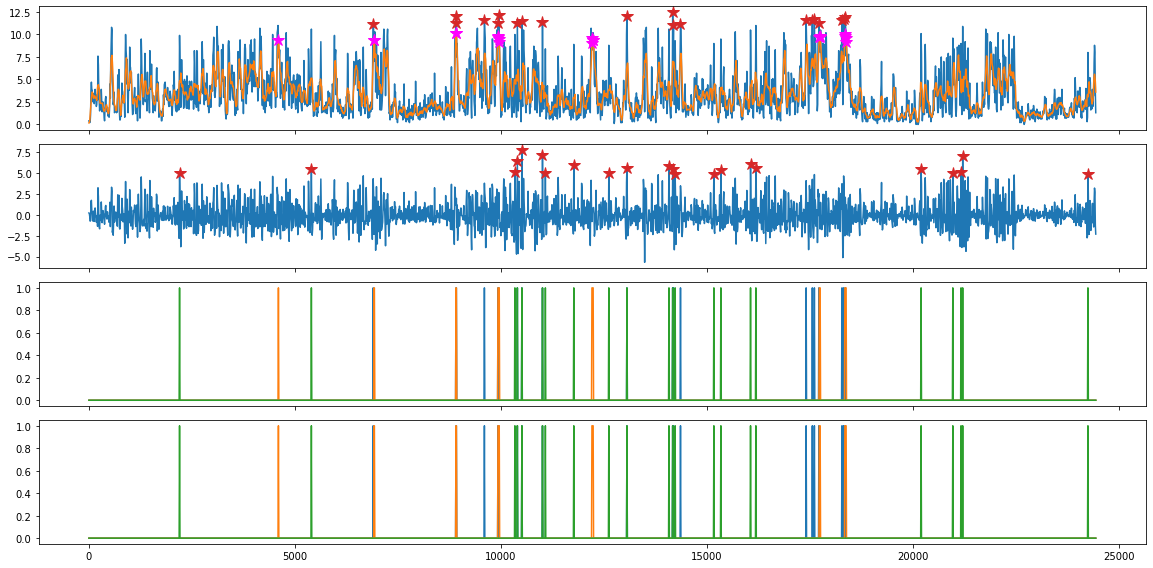

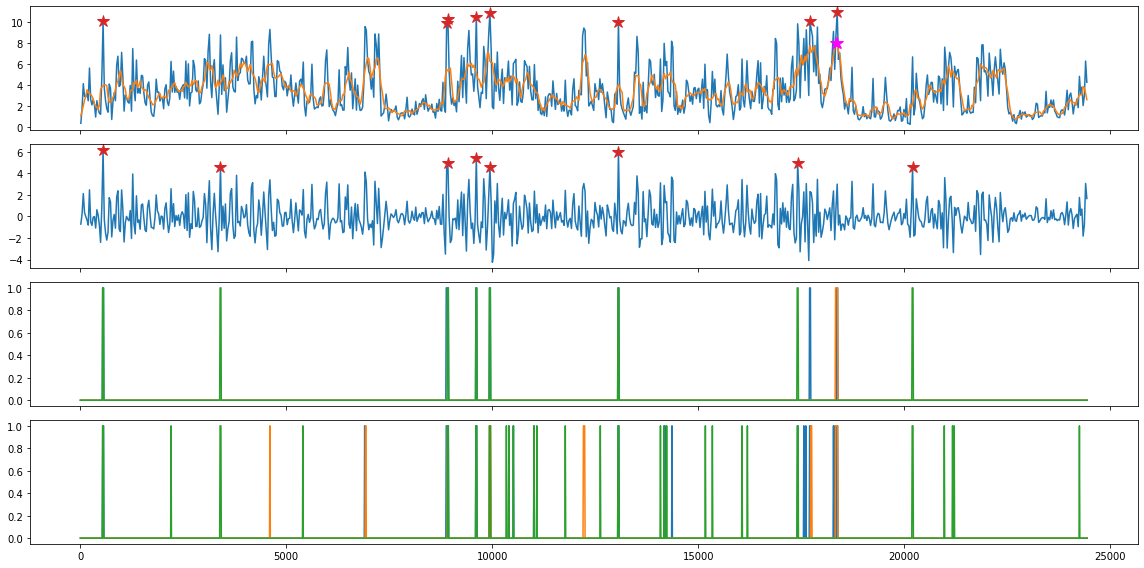

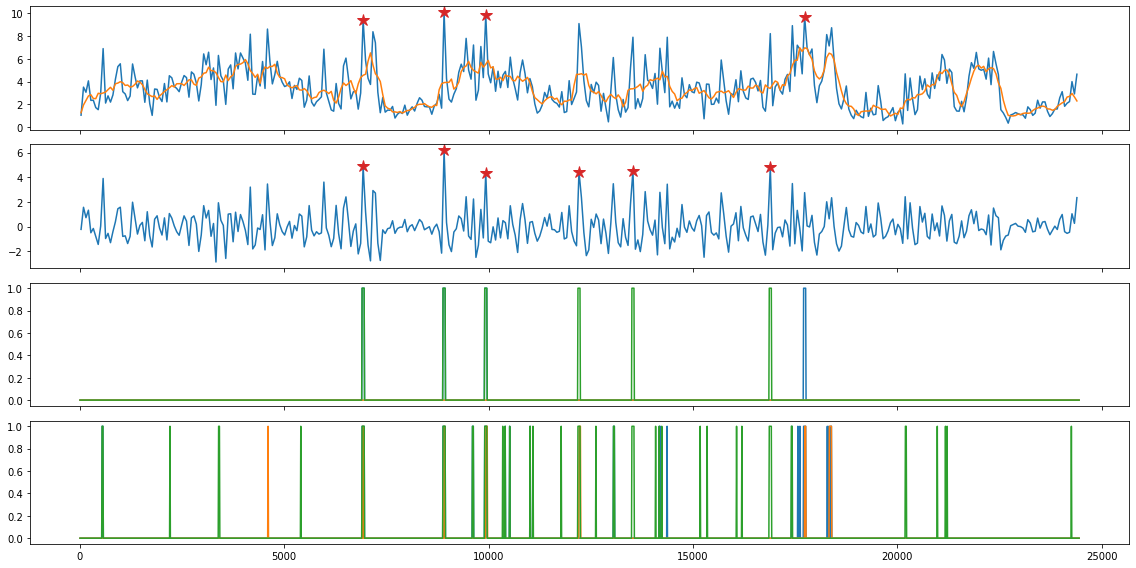

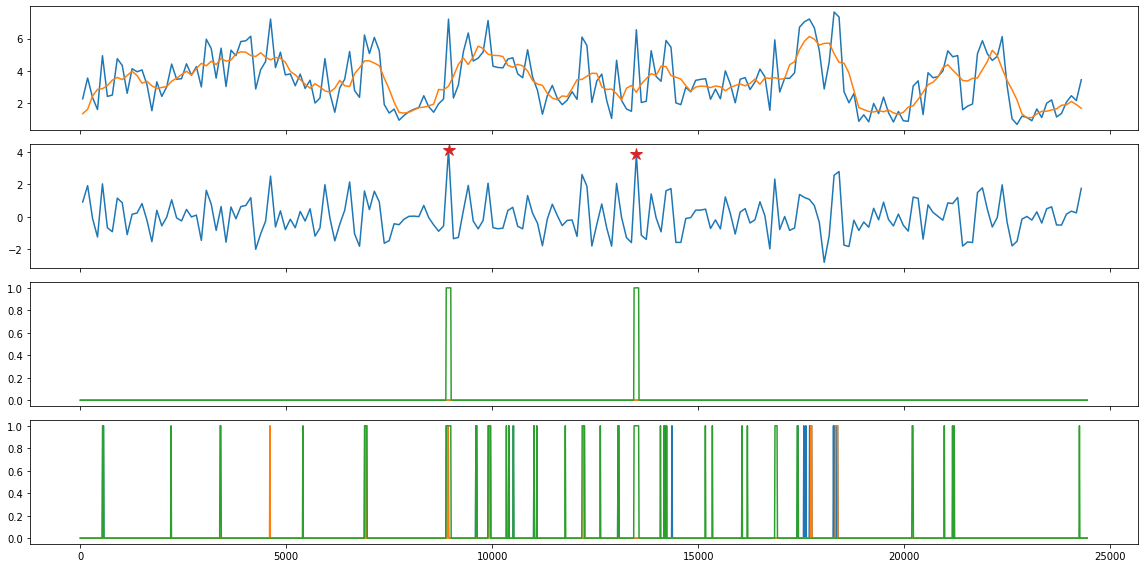

In [15]:
# for dur in [10, 30, 60, 120, 180, 300]:



for i, dur in enumerate([10, 30, 60, 120]):
# for dur in [10, 30]:
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True)
#     fig, axes = plt.subplots(1, 1, figsize=(16, 3))

    count, bins = np.histogram(chat_times, bins=range(0, int(chat_times[-1]), dur))

    axis = np.convolve(bins, [0.5, 0.5], mode='valid')
    
    if i == 0:
        unit_axis = axis
        unit_dt = (unit_axis[1] - unit_axis[0]) / 2
    
#     axes.plot(axis, count / dur)
    
#     mean_count = np.convolve(count, np.ones(6) / 6, mode='same')
#     axes.plot(axis, mean_count / dur)
#     axes.plot(axis, filter_outliers(count) / dur, '*', color='r')
    
    axes[0].plot(axis, count / dur)
    
    mean_count = np.convolve(count, np.ones(6) / 6, mode='same')
    axes[0].plot(axis, mean_count / dur)
    outliers = filter_outliers(count) / dur
    axes[0].plot(axis, outliers, '*', color='tab:red', markersize=12)
    outliers_mean = filter_outliers(mean_count) / dur
    axes[0].plot(axis, outliers_mean, '*', color='magenta', markersize=12)
    
    time_diff = (count - mean_count) / dur
    
    axes[1].plot(axis, time_diff)
    time_diff_outliers = filter_outliers(time_diff)
    axes[1].plot(axis, time_diff_outliers, '*', color='tab:red', markersize=12)
    
    outlying_idxs = [i for i, v in enumerate(outliers) if not np.isnan(v)]
    outlying_idxs_mean = [i for i, v in enumerate(outliers_mean) if not np.isnan(v)]
    outlying_idxs_time_diff  = [i for i, v in enumerate(time_diff_outliers) if not np.isnan(v)]
    
#     plt.show()
    
#     print(axis[outlying_idxs])
#     print(outlying_idxs_mean)
#     print(outlying_idxs_time_diff)

    outlying_time = axis[outlying_idxs]
    outlying_time_mean = axis[outlying_idxs_mean]
    outlying_time_diff = axis[outlying_idxs_time_diff]
    
    mask_index = copy.deepcopy(unit_axis)
    dt = (axis[1] - axis[0]) / 2
    
    outlying_mask = get_outlier_mask(outlying_time, dt, mask_index)
    outlying_mask_mean = get_outlier_mask(outlying_time_mean, dt, mask_index)
    outlying_mask_diff = get_outlier_mask(outlying_time_diff, dt, mask_index)
    
#     plt.figure(figsize=(16, 2))
    axes[2].plot(mask_index, outlying_mask)
    axes[2].plot(mask_index, outlying_mask_mean)
    axes[2].plot(mask_index, outlying_mask_diff)
    
    if i == 0:
        outlying_mask_accum = outlying_mask
        outlying_mask_mean_accum = outlying_mask_mean
        outlying_mask_diff_accum = outlying_mask_diff
    else:
        outlying_mask_accum = [a or b for a, b in zip(outlying_mask_accum, outlying_mask)]
        outlying_mask_mean_accum = [a or b for a, b in zip(outlying_mask_mean_accum, outlying_mask_mean)]
        outlying_mask_diff_accum = [a or b for a, b in zip(outlying_mask_diff_accum, outlying_mask_diff)]
    
    axes[3].plot(mask_index, outlying_mask_accum)
    axes[3].plot(mask_index, outlying_mask_mean_accum)
    axes[3].plot(mask_index, outlying_mask_diff_accum)
    
    plt.tight_layout()
    plt.show()
    print()


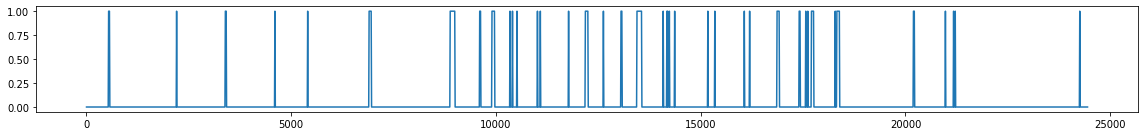

40


In [16]:
plt.figure(figsize=(16, 2))
final_mask = [a or b or c for a, b, c in zip(outlying_mask_accum, outlying_mask_mean_accum, outlying_mask_diff_accum)]
plt.plot(mask_index, final_mask)
plt.tight_layout()
plt.show()

highlight_bounds = get_highlight_bounds(mask_index, final_mask, unit_dt)

print(len(highlight_bounds))

In [17]:
# chat_messages

In [18]:
total_counter = Counter()

words = ['ㅋㅋ', 'ㅗㅜㅑ', 'ㄷㄷ', 'ㅠㅠ']
words += emoticon_id_to_string_dict.keys()

maximum_keyword_len = 2

for num, (time, chat) in enumerate(tqdm(chat_messages)):
    
    text = chat
    word_dict = dict()
    text = text_compressor(text)
    text = text_cleaner(text, ['!'])
    
    for word in words:
        if word in text:
            num_occur = text.count(word)
            text = text.replace(word, '')
            word_dict[word] = num_occur
            
    word_counter = Counter(word_dict)
    sentence_dict = dict()
    
    if len(text) > 0:
        for i in range(max(1, maximum_keyword_len), len(text) + 1):
            for j in range(0, min(len(text) - i + 1, maximum_keyword_len)):
                sentence_dict[text[j:j+i]] = 1
    
    sentence_counter = Counter(sentence_dict)
    
    total_counter += word_counter
    total_counter += sentence_counter

    if (num + 1) % 1000 == 0:
        total_counter = counter_cleaner(total_counter, 5)
#         print(len(total_counter))
        
total_counter = counter_cleaner(total_counter, 5)

print([(word, num) for word, num in total_counter.most_common(30)])


[('ㅋㅋ', 15615), ('ㄷㄷ', 2597), ('ㅗㅜㅑ', 1744), ('ㅠㅠ', 572), ('<(245)>', 428), ('누나아아', 282), ('<(302888154)>', 267), ('아니', 250), ('<(86)>', 249), ('<(303831803)>', 241), ('자꾸', 241), ("('ω')", 219), ('<(303926710)>', 202), ('파로마각', 196), ('<(302666215)>', 194), ('파로마ㄱ', 190), ('ㅣㅣ', 184), ('<(303792126)>', 177), ('리시빙', 175), ('캐시눈나아아', 174), ('인성존', 163), ('쓰레기통', 162), ('헤으응', 156), ('<(301112979)>', 151), ('아테스형', 144), ('처신잘하라고', 142), ('<(1772396)>', 134), ('으악', 132), ('갓겜', 132), ('<(81103)>', 129)]


In [19]:
partial_counter = copy.deepcopy(total_counter)

In [20]:
for key in partial_counter:
    partial_counter[key] = 0

In [26]:
partial_chat_messages_list = list()

j = 0
bound = highlight_bounds[j]

partial_chat_messages = list()

margins = 15

for time, message in chat_messages:

    if time > bound[1] + margins:
        j += 1
        if j == len(highlight_bounds):
            partial_chat_messages_list.append(partial_chat_messages)
            partial_chat_messages = list()
            break
        else:
            bound = highlight_bounds[j]
            partial_chat_messages_list.append(partial_chat_messages)
            partial_chat_messages = list()
    
    if time >= bound[0] - margins and time <= bound[1] + margins:
        partial_chat_messages.append((time, message))
        

In [58]:
print(f'Number of extracted highlights #{len(partial_chat_messages_list)}\n')

# print([len(partial_chat_messages) for partial_chat_messages in partial_chat_messages_list])

# counter_list = list()

# for partial_chat_messages in partial_chat_messages_list:
#     counter = copy.deepcopy(partial_counter)
#     counter = highlight_word_counter(partial_chat_messages, counter)
#     counter_list.append(counter.most_common(20))
    
# for bound, counter in zip(highlight_bounds, counter_list):
#     print(f'{bound[0] - margins} ~ {bound[1] + margins}')
#     print(counter)
#     print()

Number of extracted highlights #40



In [55]:
def secs_to_HHMMSS(seconds):
    HH = int(np.floor(seconds / 3600))
    seconds -= HH * 3600
    MM = int(np.floor(seconds / 60))
    seconds -= MM * 60
    SS = int(seconds)
    return f'{HH:02d}:{MM:02d}:{SS:02d}'

In [73]:
for bound, counter in zip(highlight_bounds, counter_list):
    t_start = int(bound[0] - margins)
    t_end = int(bound[1] + margins)
    
    print(f'{secs_to_HHMMSS(t_start)} ~ {secs_to_HHMMSS(t_end)}')
    print(counter)
    print()
    
#     video = videoclip.subclip(t_start, t_end)
#     video_name = f'{secs_to_HHMMSS(t_start)} ~ {secs_to_HHMMSS(t_end)}'.replace(':', '.')
#     video.write_videofile(f'{video_name}.mp4', temp_audiofile=f"{video_name}.m4a", remove_temp=True, audio_codec="aac")
#     break


00:08:45 ~ 00:09:45
[('ㅗㅜㅑ', 45), ('ㅋㅋ', 38), ('<(302888154)>', 20), ('우욱', 13), ('커하', 9), ('형수님', 8), ('으악', 8), ('파누부끄', 8), ('ㄷㄷ', 7), ('아아아', 7), ('<(1836239)>', 7), ('펀가야', 6), ('<(300770252)>', 6), ('저거', 5), ('커비용', 5), ('커네', 4), ('어우', 4), ('이건', 4), ('커비가', 4), ('<(300975095)>', 4)]

00:36:25 ~ 00:37:05
[('ㅋㅋ', 27), ('박던데', 15), ('<(300644572)>', 8), ('차돌박이', 7), ('박는데요', 4), ('<(300644597)>', 4), ('<<', 3), ("('ω'`)", 3), ('ㅗㅜㅑ', 3), ('차박이는', 3), ('여기', 3), ('가능', 2), ('차에박는다', 2), ('파누부끄', 2), ('안박아', 2), ('ㄷㄷ', 2), ('박을', 2), ('박아요', 2), ('주유구가', 2), ('박더라', 2)]

00:56:15 ~ 00:57:15
[('ㅋㅋ', 29), ('겜이에용', 19), ('똥겜이에요', 16), ('ㄷㄷ', 15), ('사도', 10), ('사치에', 9), ('사치강', 8), ('우욱', 7), ('사치코', 6), ('ㄹㅇ', 6), ('빨간마스크', 5), ('ㅁㅈ', 4), ('곰보게임', 4), ('<(301788521)>', 4), ('연말', 4), ('킁킁', 3), ('ㄸㄱㅇㅇㅇ', 3), ('와곰보', 3), ('이거', 3), ('공포겜이', 3)]

01:16:25 ~ 01:17:05
[('ㅋㅋ', 173), ('ㅗㅜㅑ', 14), ('소리에', 7), ('붕쯔붕쯔', 7), ('ㄷㄷ', 5), ('귀신이', 5), ('리듬게임', 3), ('리듬액션', 3), ('헤으응', 3), ('디디알'